## Train the word2vec model with the data from clean_data/

In [1]:
from gensim.models import Word2Vec
import pandas as pd
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [2]:
fake_pii = pd.read_csv("../clean_data/Cleaned_train_text_with_pii_2018_12_29_07_26_56_266227.csv")

In [3]:
fake_pii.head()

,Text,Labels,PII,Cleaned_text
0,Return never place become nearly movement. No ...,Address,"9479 Ward Creek Suite 474 Warnershire, NH 08434",return never place become nearly movement no s...
1,Quality recently seek Suite 937 goal relations...,Address,Suite 937,quality recently seek suite 937 goal relations...
2,Word expert reveal effect response forward. In...,Address,Apt. 925,word expert reveal effect response forward ind...
3,Son specific think. Conference its home expert...,Address,"15286 Ramirez Lakes Apt. 147 West Anthony, FL ...",son specific think conference its home expert ...
4,Control trouble Apt. 223 keep action rule. Sol...,Address,Apt. 223,control trouble apt 223 keep action rule soldi...


In [4]:
# 0 denote no pii
# 1 denote pii exists
def binary_pii(label):
    pii_label = 0
    if label != "None":
        pii_label = 1
    return pii_label 

In [5]:
fake_pii["Target"] = fake_pii['Labels'].apply(binary_pii)

In [6]:
fake_pii.head()

,Text,Labels,PII,Cleaned_text,Target
0,Return never place become nearly movement. No ...,Address,"9479 Ward Creek Suite 474 Warnershire, NH 08434",return never place become nearly movement no s...,1
1,Quality recently seek Suite 937 goal relations...,Address,Suite 937,quality recently seek suite 937 goal relations...,1
2,Word expert reveal effect response forward. In...,Address,Apt. 925,word expert reveal effect response forward ind...,1
3,Son specific think. Conference its home expert...,Address,"15286 Ramirez Lakes Apt. 147 West Anthony, FL ...",son specific think conference its home expert ...,1
4,Control trouble Apt. 223 keep action rule. Sol...,Address,Apt. 223,control trouble apt 223 keep action rule soldi...,1


In [7]:
context_sentences = [sentence.split(" ") for sentence in fake_pii.Cleaned_text]

In [8]:
%%time 
word2vec_model = Word2Vec(context_sentences, size = 100, window=5,
                                  min_count = 1, workers = 2)

CPU times: user 2min 23s, sys: 620 ms, total: 2min 24s
Wall time: 1min 17s


In [9]:
file_name = "./word2vec/"+"word2vec_cleaned_300_"+".bin"
word2vec_model.save(file_name)

## Visualize the resulting word2vec model vectors in 2d with PCA.

In [10]:
from yellowbrick.features.pca import PCADecomposition
import matplotlib.pyplot as plt

In [11]:
from word2vec_visualizer import find_part_pii, get_pii2vec_matrix, color_dict

Extract the PII part since it is most different from other part of the text.

In [12]:
from tqdm import tqdm
pii_list = [find_part_pii(text, model = word2vec_model) for text in tqdm(fake_pii["Cleaned_text"]) ]

100%|██████████| 800000/800000 [01:20<00:00, 9967.92it/s] 


Use the word2vec model to get the vector representation of the extracted PII.

In [13]:
pii_matrix = get_pii2vec_matrix(pii_list = pii_list, model = word2vec_model)

100%|██████████| 800000/800000 [00:03<00:00, 260727.19it/s]


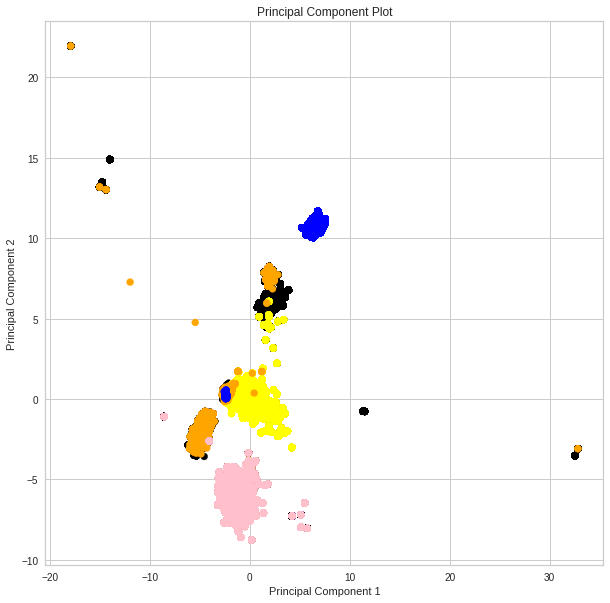

In [14]:
pii_labels = fake_pii["Labels"]
colors_map = pii_labels.map(color_dict)


plt.figure(figsize=(10,10))
PCAvisualizer = PCADecomposition(scale=True, color = colors_map, proj_dim = 2)
PCAvisualizer.fit_transform(pii_matrix, pii_labels)
PCAvisualizer.poof()

## Training some classifiers for classifications. 

### Logistic regression

In [15]:
%%time
%%notify -m "model finished training"
from sklearn.linear_model import LogisticRegression
from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

pipe = make_pipeline(LogisticRegression(random_state=0 , max_iter=10000,n_jobs = 1)

param_grid = {
    'logisticregression__C':expon(scale = 2),
    'logisticregression__penalty':['l1','l2']
}

random_cv_lr = RandomizedSearchCV(estimator= pipe, param_distributions = param_grid, cv =10, error_score = 0,
                               n_iter = 10 , scoring = 'f1', return_train_score=True,n_jobs = 2 )


random_cv_lr.fit(pii_matrix, fake_pii['Target'])

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


RandomizedSearchCV(cv=10, error_score=0,
          estimator=Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=0, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
          fit_params=None, iid='warn', n_iter=10, n_jobs=2,
          param_distributions={'logisticregression__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f3e2480c5f8>, 'logisticregression__penalty': ['l1', 'l2']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score=True, scoring='f1', verbose=0)

<IPython.core.display.Javascript object>

CPU times: user 1min 54s, sys: 1.44 s, total: 1min 55s
Wall time: 1h 50min 50s


In [16]:
binary_pred = random_cv_lr.predict(pii_matrix)
binary_true = fake_pii["Target"]

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

CPU times: user 639 ms, sys: 27.9 ms, total: 667 ms
Wall time: 636 ms


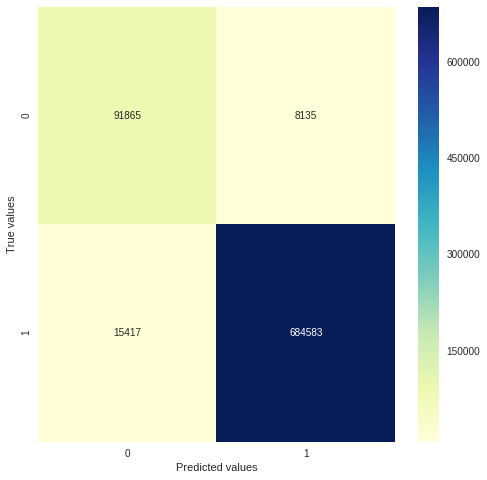

In [29]:
%%time

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")

In [19]:
%%time
%%notify -m "metric are ready"
print(classification_report(y_true = binary_true, y_pred = binary_pred))

              precision    recall  f1-score   support

           0       0.86      0.92      0.89    100000
           1       0.99      0.98      0.98    700000

   micro avg       0.97      0.97      0.97    800000
   macro avg       0.92      0.95      0.93    800000
weighted avg       0.97      0.97      0.97    800000



<IPython.core.display.Javascript object>

CPU times: user 492 ms, sys: 72.2 ms, total: 564 ms
Wall time: 476 ms


In [25]:
random_cv_lr.best_estimator_

Pipeline(memory=None,
     steps=[('logisticregression', LogisticRegression(C=0.026579876280000161, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=10000,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=0,
          solver='warn', tol=0.0001, verbose=0, warm_start=False))])

In [26]:
from sklearn.externals import joblib
joblib.dump(random_cv_lr.best_estimator_, 'word2vec_300_logistic.pkl',compress = 1)

['word2vec_300_logistic.pkl']

### Using class weights in Logistic regression

In [ ]:
%%time
%%notify -m "logistic-regression with class_weights finished training"
from sklearn.linear_model import LogisticRegression
from scipy.stats import expon
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# suppose the class_weight are 0.1 for 0 (no PII)  and 0.9 for 1 (PII exist)

pipe_lr_weights = make_pipeline(LogisticRegression(random_state=0 , max_iter=10000,n_jobs = 1,\
                                                  class_weight={0:.1, 1:.9}) )
param_grid = {
              'logisticregression__C':expon(scale = 2),
              'logisticregression__penalty':['l1','l2']
}

random_cv_lr_weights = RandomizedSearchCV(estimator= pipe_lr_weights, param_distributions = param_grid, \
                                  cv =10, error_score = 0,n_iter = 10 , scoring = 'f1', \
                                  return_train_score=True,n_jobs = 2 )
                               


random_cv_lr_weights.fit(pii_matrix, fake_pii['Target'])



In [ ]:
binary_pred = random_cv_lr_weights.predict(pii_matrix)
binary_true = fake_pii["Target"]

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

%%time

import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize= (8,8))
sns.heatmap(confusion_matrix(y_true = binary_true, y_pred = binary_pred), annot = True,fmt="d",cmap="YlGnBu")
plt.xlabel("Predicted values")
plt.ylabel("True values")

In [ ]:
%%time
%%notify -m "metric are ready"
print(classification_report(y_true = binary_true, y_pred = binary_pred))

In [ ]:
random_cv_lr_weights.best_estimator_

In [ ]:
from sklearn.externals import joblib
joblib.dump(random_cv_lr_weights.best_estimator_, 'word2vec_300_logistic_with_weights.pkl',compress = 1)

## Run some more complex and long-running models in AWS.

### Random forest

In [ ]:
# %%time 
# %%notify -m "random forest model is ready"
# from sklearn.ensemble import RandomForestClassifier

# pipe_rf = make_pipeline(RandomForestClassifier())

# from scipy.stats import randint

# param_grid = {
#     'randomforestclassifier__criterion':['gini', 'entropy'],
#     'randomforestclassifier__n_estimators':randint(100,5000)
# }

# random_cv_rf = RandomizedSearchCV(estimator = pipe_rf,param_distributions = param_grid,\
#                                   cv =2, error_score = 0,n_iter = 2 , scoring = 'f1',\
#                                   return_train_score=True, n_jobs = 2)
# random_cv_rf.fit(pii_matrix, fake_pii['Target'])                     

### Xgboost

In [ ]:
# %%time 
# %%notify -m "Xgboost model is ready"
# from xgboost import XGBClassifier


# from scipy.stats import randint, uniform
# pipe_xgboost = make_pipeline(XGBClassifier())
# param_grid = {
#     'xgbclassifier__booster':['gbtree', 'gblinear','dart'],
#     'xgbclassifier__n_estimators':randint(100,1000),
#     'xgbclassifier__gamma':uniform(0,10),
#     "xgbclassifier__learning_rate":uniform(0,1),
#     'xgbclassifier__nthread':[2],
#     'xgbclassifier__max_depth':randint(1,10)    
# }

# random_cv_xgboost = RandomizedSearchCV(estimator = pipe_xgboost, param_distributions = param_grid,\
#                                        cv =10, error_score = 0,n_iter = 10 , scoring = 'f1'\
#                                        ,return_train_score=True, n_jobs = 2)
# random_cv_xgboost.fit(pii_matrix, fake_pii['Target'])

# Appendix

In [ ]:
import inspect

In [ ]:
color_dict

In [ ]:
print(inspect.getsource(find_part_pii))

In [ ]:
print(inspect.getsource(get_pii2vec_matrix))